## I. Imports + data loading

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from typing import Iterable, Union
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
start = dt.datetime(2021,11,10)   # Rivian's IPO date
end = dt.datetime.today().date()

In [4]:
sp500_ticker = ('^GSPC')
rivian_ticker = ('RIVN')
tesla_ticker = ('TSLA')
mullen_ticker = ('MULN')
lucid_ticker = ('LCID')

In [5]:
# Loading the datasets for each asset
sp500_df = reader.get_data_yahoo(sp500_ticker, start, end)
rivn_df = reader.get_data_yahoo(rivian_ticker, start, end)
tsla_df = reader.get_data_yahoo(tesla_ticker, start, end)
muln_df = reader.get_data_yahoo(mullen_ticker, start, end)
lcid_df = reader.get_data_yahoo(lucid_ticker, start, end)

In [6]:
rivn_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-10,119.459999,95.199997,106.750000,100.730003,103679500.0,100.730003
2021-11-11,125.000000,108.010002,114.625000,122.989998,83668200.0,122.989998
2021-11-12,135.199997,125.250000,128.645004,129.949997,50437500.0,129.949997
2021-11-15,152.529999,127.510002,130.800003,149.360001,64982300.0,149.360001
2021-11-16,179.470001,153.779999,163.800003,172.009995,94036600.0,172.009995


We are limited by the size of our datasets at the moment, because we can only compare these EV motor stocks from November 2021 onwards (as this is the first date when we would have stock price data for all 4 assets chosen for this analysis). In addition, with the large amount of volatility (as of March 2022) due to (1) Fed's potential increase of interest rates this year and (2) Russia v Ukraine crisis --> rising commodity prices, we may need more data going forward to deduce reliable patterns from this analysis. 

## II. Preprocess input dfs

In [7]:
def preprocess_dfs(list_of_dfs: Iterable) -> Iterable:
    processed_dfs = []
    for df in list_of_dfs:
        df = df.rename(columns={"Adj Close": "closing_price"})
        processed_dfs += [df.reset_index()]
    
    return processed_dfs

In [8]:
def calculate_daily_returns(list_of_dfs: Iterable) -> Iterable:
    enriched_dfs = []
    
    for df in list_of_dfs:
        df["daily_return"] = np.log(df["closing_price"]/df["closing_price"].shift())
        df = df.dropna()
        enriched_dfs += [df]
    
    return enriched_dfs

In [9]:
processed_dfs = preprocess_dfs([sp500_df, rivn_df, tsla_df, muln_df, lcid_df])

In [10]:
processed_dfs = calculate_daily_returns(processed_dfs)

In [11]:
sp500_df, rivn_df, tsla_df, muln_df, lcid_df = processed_dfs

## III. Exploratory plots

In [12]:
ticker_list = [rivian_ticker, mullen_ticker, tesla_ticker, lucid_ticker]
ticker_to_df = {rivian_ticker: rivn_df, mullen_ticker: muln_df, tesla_ticker: tsla_df, lucid_ticker: lcid_df}

Text(0, 0.5, 'Daily return')

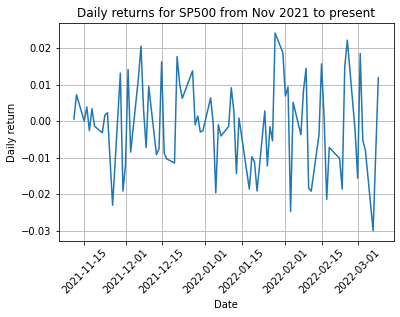

In [81]:
# Plotting S&P500 returns

plt.plot(sp500_df["Date"], sp500_df["daily_return"])
plt.grid()
plt.xticks(rotation=45)
plt.title(f"Daily returns for SP500 from Nov 2021 to present")
plt.xlabel("Date")
plt.ylabel("Daily return")

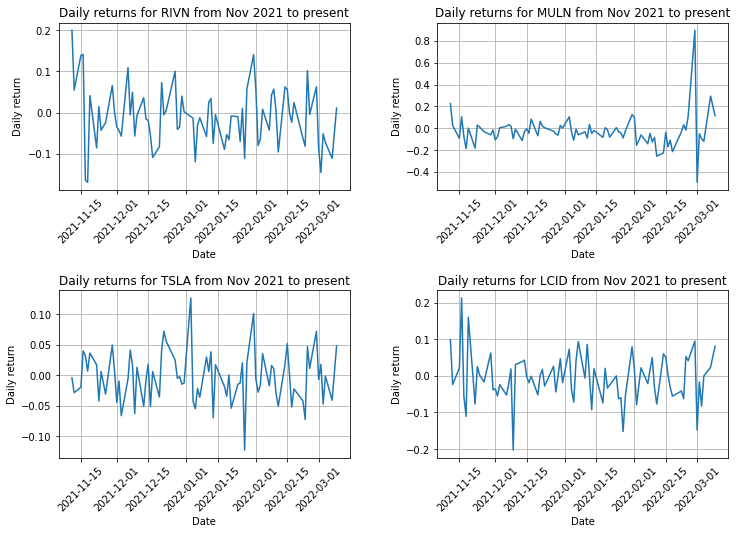

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(12, 8))

grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.6)

for i in range(0, 2):
    for j in range(0, 2):
        index = i*2+j
        target_ticker = ticker_list[index]
        df = ticker_to_df[target_ticker]
        ax = plt.subplot(grid[i, j])
        plt.plot(df["Date"], df["daily_return"])
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(f"Daily returns for {target_ticker} from Nov 2021 to present")
        plt.xlabel("Date")
        plt.ylabel("Daily return")

plt.show()

As mentioned earlier, we see a large amount of volatility in these EV motor stocks. While our daily returns varying between +/- 2% for our standard index, the same for EV motor stocks is, on average, at least +/- 10%. Apart from the geo-political effects on volatility in general, all of these EV motor companies except Tesla are at the scale-up phase of a growing industry. LCID, MULN, and RIVN have negative EBITDAs, which makes them even more susceptible to the tech-stock selloffs happening recently.

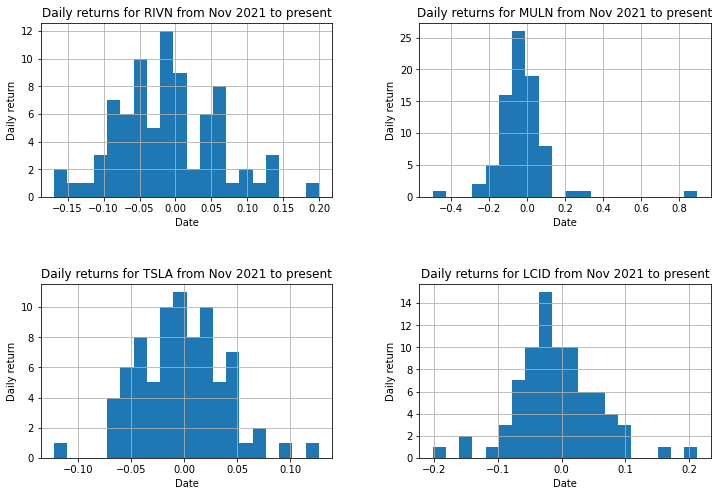

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(12, 8))

grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)

for i in range(0, 2):
    for j in range(0, 2):
        index = i*2+j
        target_ticker = ticker_list[index]
        df = ticker_to_df[target_ticker]
        ax = plt.subplot(grid[i, j])
        plt.hist(df["daily_return"], bins=20)
        plt.grid()
        plt.title(f"Daily returns for {target_ticker} from Nov 2021 to present")
        plt.xlabel("Date")
        plt.ylabel("Daily return")

plt.show()

While daily returns have a wide range for the chosen assets, they do tend to be centered around 0% and are not particularly skewed to any one side. This can be useful for further analysis in the future.

## IV. Exploring correlation between EV motor stocks

In [15]:
daily_returns_df = pd.DataFrame()
for ticker in ticker_list:
    df = ticker_to_df[ticker]
    col_name = ticker+"_daily_return"
    daily_returns_df[col_name] = df["daily_return"]

daily_returns_df["SP500_daily_return"] = sp500_df["daily_return"]

[Text(0.5, 1.0, 'Is pairs-trading possible with EV stocks?')]

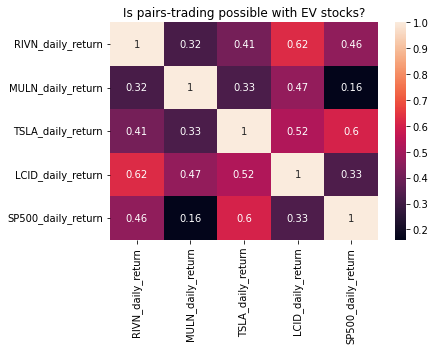

In [16]:
sns.heatmap(daily_returns_df.corr(), annot=True).set(title="Is pairs-trading possible with EV stocks?")

Pairs trading is appropriate if the correlation between two stocks is > 0.8. This does not seem to be the case for any pairs of our chosen EV stocks. The pair (LCID, RIVN) has the highest correlation in daily returns, so this may be a useful pair to explore in the future. The relationship between TSLA and SP500 may not be one to further build on, as Tesla is part of the SP500 index. 

**We looked at how each stock correlates with one another, but we can be a bit more lenient in our next checks:**
1. For a pair of EV motor stocks, does one stock having positive returns means the other stock will too?
2. For a pair of EV motor stocks, if one stock beats market returns, does that mean the other stock will too?

In [21]:
returns_wrt_index_df = daily_returns_df.drop("SP500_daily_return", axis=1)

for col in returns_wrt_index_df.columns:
    returns_wrt_index_df[col] = returns_wrt_index_df[col] - sp500_df["daily_return"]

In [30]:
returns_binary_df = daily_returns_df.drop("SP500_daily_return", axis=1)
returns_binary_df = (returns_binary_df >= 0)
returns_binary_df = returns_binary_df.replace({True: "Up", False: "Down"})

In [31]:
returns_binary_wrt_index_df = (returns_wrt_index_df >= 0)
returns_binary_wrt_index_df = returns_binary_wrt_index_df.replace({True: "Up", False: "Down"})

In [40]:
def generate_comparison_cf_matrix(df: pd.DataFrame, ticker1: str, ticker2: str, wrt_market: bool = False) -> None:
    col1 = ticker1 + "_daily_return"
    col2 = ticker2 + "_daily_return"
    
    cf_matrix = confusion_matrix(df[col1], df[col2], normalize="all")

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    if wrt_market:
        ax.set_title(f'How often do {ticker1} and {ticker2} beat the market together (or vice versa)? \n')
        ax.set_xlabel(f'\n {ticker2} daily return - SP500 daily return')
        ax.set_ylabel(f'{ticker1} daily return - SP500 daily return')
        ax.xaxis.set_ticklabels(['Lower than market','Better than market'])
        ax.yaxis.set_ticklabels(['Lower than market','Better than market'])
    else:
        ax.set_title(f'How often do {ticker1} and {ticker2} move in the same direction? \n')
        ax.set_xlabel(f'\n {ticker2} daily return')
        ax.set_ylabel(f'{ticker1} daily return');
        ax.xaxis.set_ticklabels(['Down','Up'])
        ax.yaxis.set_ticklabels(['Down','Up'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [47]:
def generate_comparison_cf_matrix(df: pd.DataFrame, ticker1: str, ticker2: str, wrt_market: bool = False) -> None:
    col1 = ticker1 + "_daily_return"
    col2 = ticker2 + "_daily_return"
    
    cf_matrix = confusion_matrix(df[col1], df[col2], normalize="all")

    return cf_matrix

In [66]:
def plot_comparison_cf_matrices(ticker1: str, ticker2: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 8))
    fig.suptitle(f"{ticker1} v {ticker2}")

    cfmatrix_1 = generate_comparison_cf_matrix(returns_binary_df, ticker1, ticker2)
    sns.heatmap(cfmatrix_1, annot=True, cmap='Blues', ax = ax[0])
    ax[0].set_title(f'How often do {ticker1} and {ticker2} move in the same direction? \n')
    ax[0].set_xlabel(f'\n {ticker2} daily return')
    ax[0].set_ylabel(f'{ticker1} daily return');
    ax[0].xaxis.set_ticklabels(['Down','Up'])
    ax[0].yaxis.set_ticklabels(['Down','Up'])

    cfmatrix_2 = generate_comparison_cf_matrix(returns_binary_wrt_index_df, ticker1, ticker2, wrt_market=True)
    sns.heatmap(cfmatrix_2, annot=True, cmap='Blues',ax = ax[1])
    ax[1].set_title(f'How often do {ticker1} and {ticker2} beat the market together (or vice versa)? \n')
    ax[1].set_xlabel(f'\n {ticker2} daily return - SP500 daily return')
    ax[1].set_ylabel(f'{ticker1} daily return - SP500 daily return')
    ax[1].xaxis.set_ticklabels(['Lower than market','Better than market'])
    ax[1].yaxis.set_ticklabels(['Lower than market','Better than market'])

    plt.subplots_adjust(wspace=0.7)
    
    plt.show()

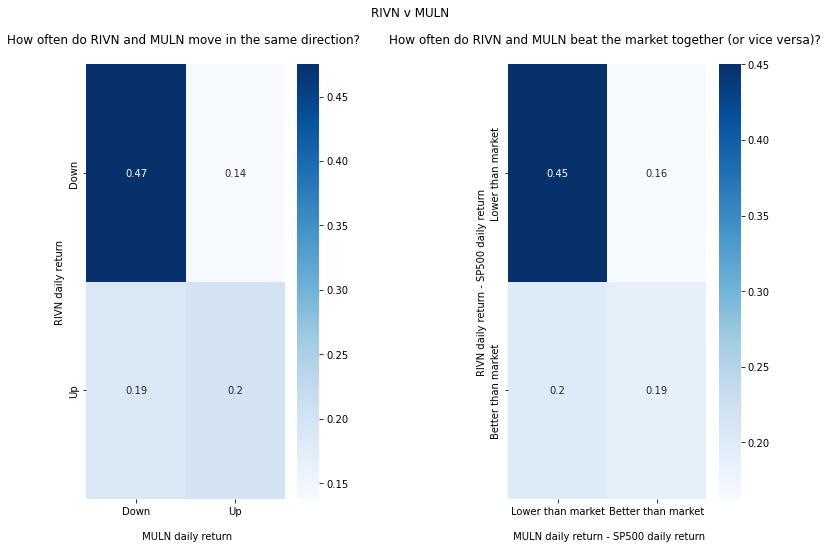

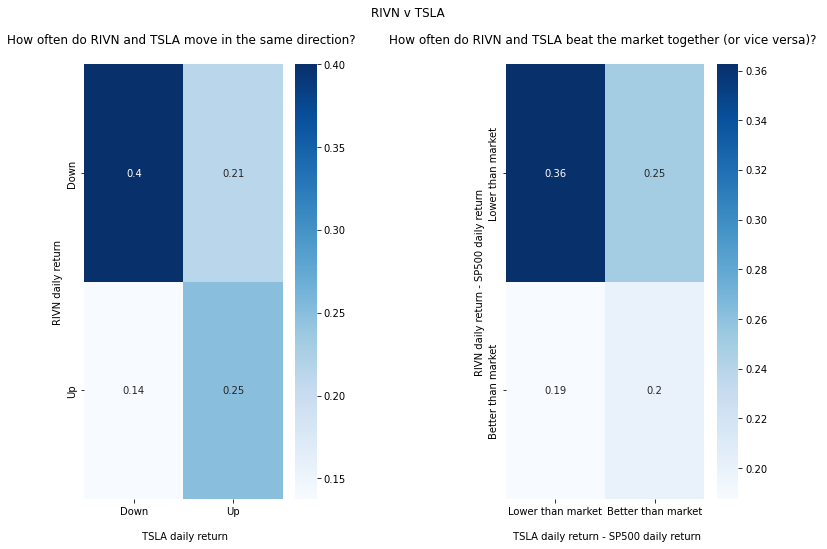

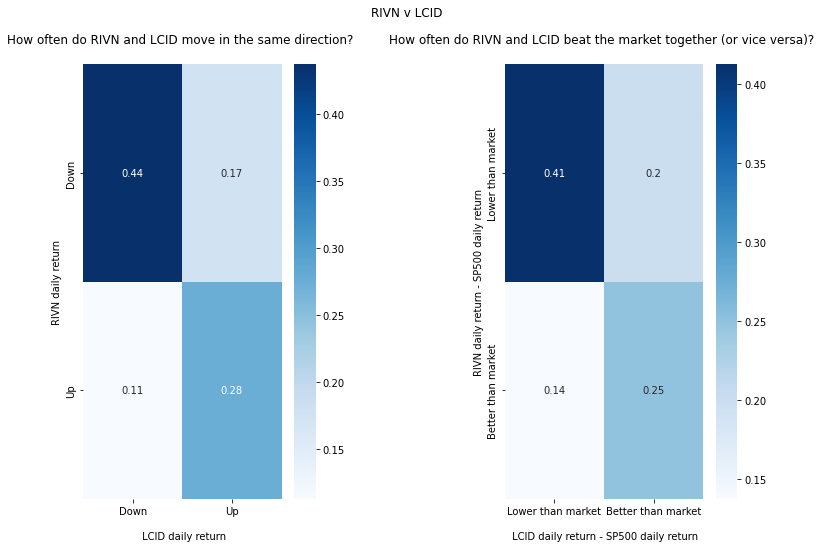

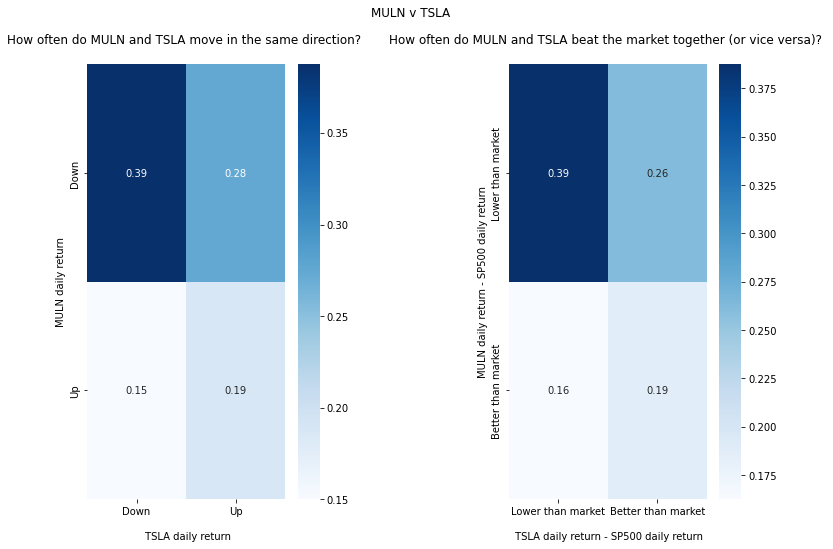

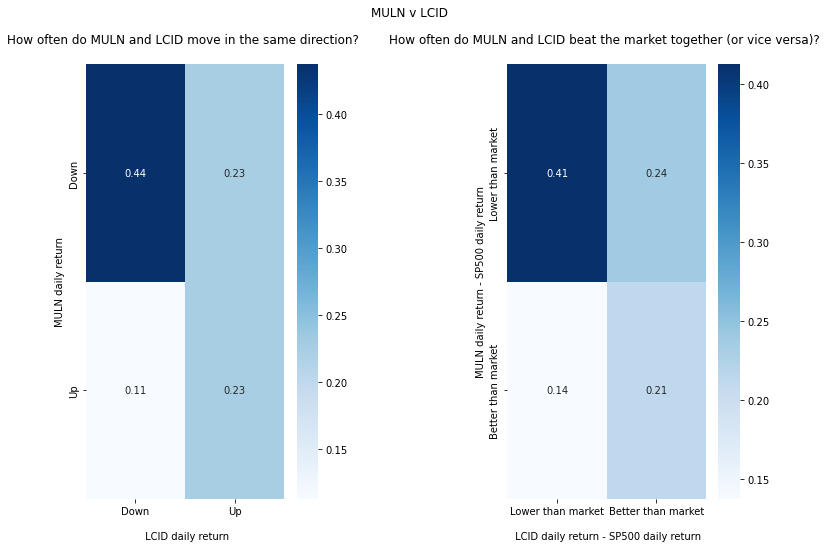

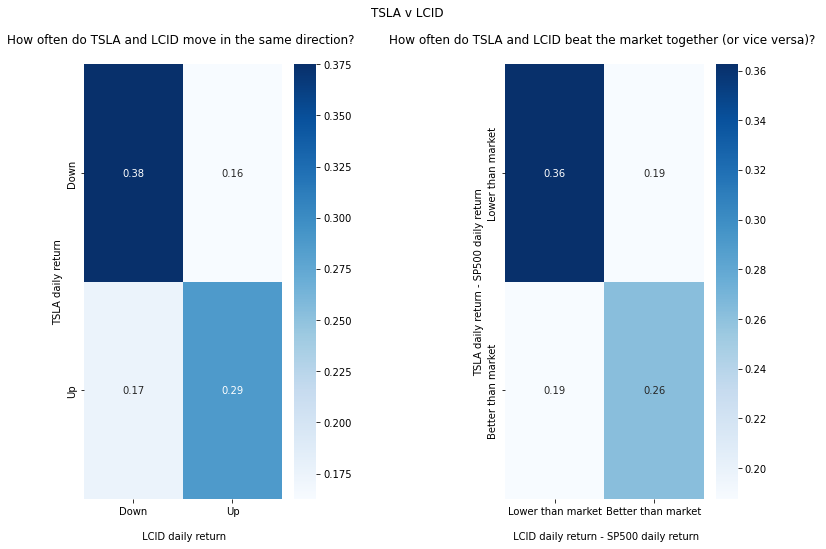

In [79]:
for pair in itertools.combinations(ticker_list, 2):
    plot_comparison_cf_matrices(pair[0], pair[1])

## V. Conclusions

Please note that many of the points below may already make sense intuitively. This notebook just serves to validate some of this intuition using exploratory data analysis:
1. Even though it may be useful to consider certain pairs of EV motor stocks for further analysis, pairs-trading with EV motor stocks will not be the best way to proceed forward.
2. It is more likely than not for EV motor stocks to move up or down together.
3. It is more likely than not for EV motor stocks to beat the market (or not) together. 
4. LCID+RIVN is the most correlated pair on daily returns.

**It will be an interesting exercise to explore the application of copulas to evaluate correlation of daily returns amongst these pairs.**